# Solving the Van der Pol oscillator with the DeepXDE Framework
Raihaan Usman, UROP Student

DeepXDE is a data-driven framework developed by researchers at Brown University.

In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

Using backend: tensorflow.compat.v1

2022-07-28 12:42:46.648248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-28 12:42:46.648282: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2022-07-28 12:43:02.714512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-28 12:43:02.714555: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-28 12:43:02.714578: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-baf76a): /proc/driver/nvidia/version does not exist


### Van der Pol Solver

Compiling model...
Building feed-forward neural network...
'build' took 0.061796 s



/opt/python/3.10.4/lib/python3.10/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+202=202. 
  warnings.warn("The balance properties of Sobol' points require "
/opt/python/3.10.4/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-07-28 12:43:11.206348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.501109 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.82e-03, 1.25e-01, 6.27e-04]    [6.82e-03, 1.25e-01, 6.27e-04]    []  


2022-07-28 12:43:11.654471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


1000      [8.62e-03, 7.32e-04, 2.61e-05]    [8.66e-03, 7.32e-04, 2.61e-05]    []  
2000      [1.14e-03, 8.74e-05, 2.02e-06]    [1.11e-03, 8.74e-05, 2.02e-06]    []  
3000      [8.53e-05, 4.62e-05, 4.81e-08]    [8.43e-05, 4.62e-05, 4.81e-08]    []  
4000      [1.27e-06, 2.21e-09, 2.62e-10]    [1.01e-06, 2.21e-09, 2.62e-10]    []  
5000      [6.58e-06, 9.79e-07, 2.43e-09]    [5.71e-06, 9.79e-07, 2.43e-09]    []  
6000      [1.23e-06, 1.18e-09, 1.96e-11]    [1.07e-06, 1.18e-09, 1.96e-11]    []  
7000      [7.97e-07, 9.19e-11, 9.41e-10]    [7.10e-07, 9.19e-11, 9.41e-10]    []  
8000      [1.16e-05, 2.38e-06, 6.70e-10]    [1.17e-05, 2.38e-06, 6.70e-10]    []  
9000      [9.97e-05, 2.50e-05, 3.72e-07]    [9.90e-05, 2.50e-05, 3.72e-07]    []  
10000     [3.40e-06, 5.56e-07, 4.85e-09]    [3.31e-06, 5.56e-07, 4.85e-09]    []  
11000     [1.53e-05, 9.60e-07, 4.32e-09]    [1.51e-05, 9.60e-07, 4.32e-09]    []  
12000     [8.25e-05, 4.53e-06, 4.39e-08]    [8.20e-05, 4.53e-06, 4.39e-08]    []  
1300

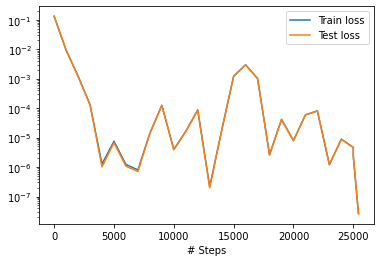

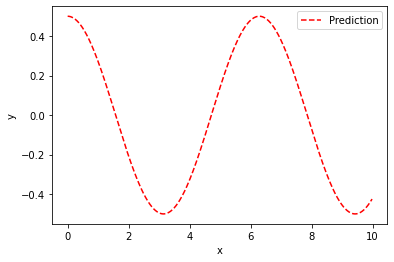

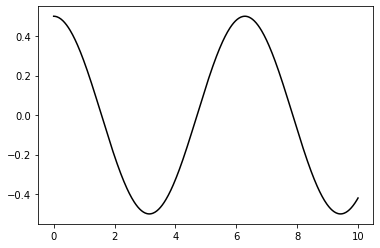

In [2]:
# PDE parameters
mu = 0
X0 = [0.5, 0]
tf = 10

# Hyperparameters
alpha           = 0.005
loss_weights    = [2, 0.5, 0.05]    # [X, x1(0), x2(0)] errors

# VdP oscillator
ODE         = lambda X, t:  np.array([X[1], mu*(1-X[0]**2)*X[1]-X[0]])
true_sol    = lambda t:     odeint(ODE, X0, t)

# The PDE problem
def VdP(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    d2y_dt2 = dde.grad.hessian(y, t)
    return  d2y_dt2 - mu * (1 - y ** 2) * dy_dt + y

# Time domain definition
geom = dde.geometry.TimeDomain(0, tf)


# Boundary return function - for Time Domain
def boundary_l(t, on_initial):
    return on_initial and np.isclose(t[0], 0)


''' Passive ICs are used! '''

# x1(0) = 0.5
def bc_func1(inputs, outputs, X):
    return outputs - 0.5

# x2(0) = 0
def bc_func2(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=None)


# ic1 = dde.icbc.IC(geom, lambda x: -1, lambda _, on_initial: on_initial)
ic1 = dde.icbc.OperatorBC(geom, bc_func1, boundary_l)
ic2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_l)

# Define the PDE problem
data = dde.data.TimePDE(geom, VdP, [ic1, ic2], 200, 2, num_test=500)

# Solver architecture
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# Create a Model using the PDE and neural network definitions
model = dde.Model(data, net)

# Compile the model!
model.compile(
    "adam", lr=alpha, loss_weights=loss_weights     # Removed metrics=["l2 relative error"]
)
losshistory, train_state = model.train(iterations=25000)

# Recompile with new optimizer L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


t = np.linspace(0, tf, 500)
sol = true_sol(t)
x1, x2 = np.hsplit(true_sol(t), 2)

plt.plot(t, x1, color="black", label="x1")
